# 03_model_training_electra.ipynb
- Fine-tuning du modèle ELECTRA-Small pour la classification de sentiments sur Twitter
# 1 - Imports & configuration

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
# from transformers import AlbertTokenizer, AlbertForSequenceClassification, TextClassificationPipeline
from transformers import ElectraTokenizerFast, ElectraForSequenceClassification, TextClassificationPipeline

import os
project_root = os.path.abspath("..")
os.chdir(project_root)

import sys
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from src.model_training import train_electra_pipeline
from src.utils.tracking_utils import log_gpu_info
from src.utils.evaluation_utils import evaluate_model_predictions
from src.utils.device_utils import check_gpu
from src.utils.visualization_utils import plot_confusion_matrix
from src.utils.inference_utils import predict_with_electra
from src.evaluate import evaluate_classification_metrics

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
print("Répertoire actif :", os.getcwd())

Répertoire actif : c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2


In [3]:
device = check_gpu()

🔍 Vérification GPU (torch, tensorflow, nvidia-smi)...
✅ torch.cuda : NVIDIA GeForce GTX 1060 6GB (CUDA 11.8)
✅ TensorFlow : /physical_device:GPU:0 (CUDA 64_112, cuDNN 64_8)
✅ nvidia-smi : disponible
| NVIDIA-SMI 560.94                 Driver Version: 560.94         CUDA Version: 12.6     |


# 2 - Chargement des données nettoyées

In [4]:
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [5]:
file_path = "data/processed/tweets_cleaned.csv"
if not os.path.exists(file_path):
    raise FileNotFoundError(f"Fichier introuvable : {file_path}")

In [6]:
df = pd.read_csv(file_path)

df = df.dropna(subset = ["text", "label"]).copy()
df["text"] = df["text"].astype(str)
df["label"] = df["label"].astype(int)

In [7]:
X = df["text"].tolist()
y = df["label"].tolist()

In [8]:
y = [int(label) for label in y]
assert set(y).issubset({0, 1}), f"⚠️ Labels invalides détectés : {set(y)}"

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99735 entries, 0 to 99999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        99735 non-null  int32 
 1   text         99735 non-null  object
 2   text_length  99735 non-null  int64 
dtypes: int32(1), int64(1), object(1)
memory usage: 2.7+ MB


# 3 - Découpage train / test

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 70)

# 4 - Entraînement du modèle ELECTRA

In [ ]:
model, tokenizer = train_electra_pipeline(
    X_train = X_train,
    y_train = y_train,
    X_test = X_test,
    y_test = y_test,
    model_dir = "models/electra_model",
    force_retrain = False
)

c:\Users\motar\Desktop\1-openclassrooms\AI_Engineer\1-projets\P09\P9_V2\venv_P9_V2\lib\site-packages\torch\_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at models/hf_assets/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


🧪 Fichiers attendus dans models/electra_model :
   ✅ config.json
   ❌ pytorch_model.bin
   ✅ tokenizer_config.json
   ✅ special_tokens_map.json
   ✅ tokenizer.json

🧠 model_files_ok = False / force_retrain = True

⚙️ Fine-tuning du modèle Electra depuis les assets Hugging Face...


  0%|          | 51/14961 [00:07<35:17,  7.04it/s] 

{'loss': 0.6895, 'grad_norm': 0.8693640828132629, 'learning_rate': 1.9933159548158546e-05, 'epoch': 0.01}


  1%|          | 101/14961 [00:14<34:41,  7.14it/s]

{'loss': 0.6832, 'grad_norm': 1.4197821617126465, 'learning_rate': 1.9866319096317094e-05, 'epoch': 0.02}


  1%|          | 151/14961 [00:21<34:17,  7.20it/s]

{'loss': 0.67, 'grad_norm': 1.9311121702194214, 'learning_rate': 1.979947864447564e-05, 'epoch': 0.03}


  1%|▏         | 201/14961 [00:28<34:23,  7.15it/s]

{'loss': 0.6335, 'grad_norm': 3.8166089057922363, 'learning_rate': 1.9732638192634183e-05, 'epoch': 0.04}


  2%|▏         | 251/14961 [00:35<34:01,  7.20it/s]

{'loss': 0.581, 'grad_norm': 5.589807510375977, 'learning_rate': 1.9665797740792728e-05, 'epoch': 0.05}


  2%|▏         | 301/14961 [00:42<34:12,  7.14it/s]

{'loss': 0.564, 'grad_norm': 8.643754005432129, 'learning_rate': 1.9598957288951276e-05, 'epoch': 0.06}


  2%|▏         | 351/14961 [00:49<33:49,  7.20it/s]

{'loss': 0.5642, 'grad_norm': 3.324772357940674, 'learning_rate': 1.953211683710982e-05, 'epoch': 0.07}


  3%|▎         | 401/14961 [00:56<33:44,  7.19it/s]

{'loss': 0.5623, 'grad_norm': 5.833929061889648, 'learning_rate': 1.9465276385268365e-05, 'epoch': 0.08}


  3%|▎         | 451/14961 [01:03<33:55,  7.13it/s]

{'loss': 0.559, 'grad_norm': 5.457231521606445, 'learning_rate': 1.9398435933426913e-05, 'epoch': 0.09}


  3%|▎         | 501/14961 [01:10<33:25,  7.21it/s]

{'loss': 0.5155, 'grad_norm': 4.135299205780029, 'learning_rate': 1.9331595481585457e-05, 'epoch': 0.1}


  4%|▎         | 551/14961 [01:17<33:25,  7.18it/s]

{'loss': 0.5091, 'grad_norm': 5.066531658172607, 'learning_rate': 1.9264755029744e-05, 'epoch': 0.11}


  4%|▍         | 601/14961 [01:24<33:20,  7.18it/s]

{'loss': 0.5075, 'grad_norm': 5.552704811096191, 'learning_rate': 1.9197914577902546e-05, 'epoch': 0.12}


  4%|▍         | 651/14961 [01:31<32:58,  7.23it/s]

{'loss': 0.4763, 'grad_norm': 3.5150234699249268, 'learning_rate': 1.9131074126061094e-05, 'epoch': 0.13}


  5%|▍         | 701/14961 [01:38<33:27,  7.10it/s]

{'loss': 0.505, 'grad_norm': 5.107295513153076, 'learning_rate': 1.906423367421964e-05, 'epoch': 0.14}


  5%|▌         | 751/14961 [01:45<33:34,  7.06it/s]

{'loss': 0.4765, 'grad_norm': 4.508216857910156, 'learning_rate': 1.8997393222378183e-05, 'epoch': 0.15}


  5%|▌         | 801/14961 [01:52<32:42,  7.21it/s]

{'loss': 0.4927, 'grad_norm': 4.725409030914307, 'learning_rate': 1.893055277053673e-05, 'epoch': 0.16}


  6%|▌         | 851/14961 [01:59<33:04,  7.11it/s]

{'loss': 0.5213, 'grad_norm': 5.104159355163574, 'learning_rate': 1.8863712318695275e-05, 'epoch': 0.17}


  6%|▌         | 901/14961 [02:06<32:30,  7.21it/s]

{'loss': 0.5121, 'grad_norm': 8.81415843963623, 'learning_rate': 1.879687186685382e-05, 'epoch': 0.18}


  6%|▋         | 951/14961 [02:13<32:35,  7.16it/s]

{'loss': 0.4904, 'grad_norm': 6.102579593658447, 'learning_rate': 1.8730031415012368e-05, 'epoch': 0.19}


  7%|▋         | 1001/14961 [02:19<32:21,  7.19it/s]

{'loss': 0.476, 'grad_norm': 5.246956825256348, 'learning_rate': 1.8663190963170912e-05, 'epoch': 0.2}


  7%|▋         | 1051/14961 [02:26<32:17,  7.18it/s]

{'loss': 0.4653, 'grad_norm': 3.8667869567871094, 'learning_rate': 1.8596350511329457e-05, 'epoch': 0.21}


  7%|▋         | 1101/14961 [02:33<32:07,  7.19it/s]

{'loss': 0.4791, 'grad_norm': 5.0833539962768555, 'learning_rate': 1.8529510059488e-05, 'epoch': 0.22}


  8%|▊         | 1151/14961 [02:40<31:45,  7.25it/s]

{'loss': 0.4543, 'grad_norm': 11.22723388671875, 'learning_rate': 1.846266960764655e-05, 'epoch': 0.23}


  8%|▊         | 1201/14961 [02:47<32:06,  7.14it/s]

{'loss': 0.4836, 'grad_norm': 4.632715702056885, 'learning_rate': 1.8395829155805094e-05, 'epoch': 0.24}


  8%|▊         | 1251/14961 [02:54<31:39,  7.22it/s]

{'loss': 0.4411, 'grad_norm': 2.497865915298462, 'learning_rate': 1.832898870396364e-05, 'epoch': 0.25}


  9%|▊         | 1301/14961 [03:01<31:38,  7.19it/s]

{'loss': 0.4617, 'grad_norm': 6.188772201538086, 'learning_rate': 1.8262148252122186e-05, 'epoch': 0.26}


  9%|▉         | 1351/14961 [03:08<31:16,  7.25it/s]

{'loss': 0.4706, 'grad_norm': 3.4203546047210693, 'learning_rate': 1.819530780028073e-05, 'epoch': 0.27}


  9%|▉         | 1401/14961 [03:15<31:11,  7.25it/s]

{'loss': 0.4633, 'grad_norm': 4.304025173187256, 'learning_rate': 1.8128467348439275e-05, 'epoch': 0.28}


 10%|▉         | 1451/14961 [03:22<31:10,  7.22it/s]

{'loss': 0.4593, 'grad_norm': 7.20688533782959, 'learning_rate': 1.806162689659782e-05, 'epoch': 0.29}


 10%|█         | 1501/14961 [03:29<31:02,  7.23it/s]

{'loss': 0.4465, 'grad_norm': 7.071774959564209, 'learning_rate': 1.7994786444756368e-05, 'epoch': 0.3}


 10%|█         | 1551/14961 [03:35<30:57,  7.22it/s]

{'loss': 0.4594, 'grad_norm': 5.005919933319092, 'learning_rate': 1.7927945992914916e-05, 'epoch': 0.31}


 11%|█         | 1601/14961 [03:42<31:03,  7.17it/s]

{'loss': 0.4622, 'grad_norm': 3.079528331756592, 'learning_rate': 1.786110554107346e-05, 'epoch': 0.32}


 11%|█         | 1651/14961 [03:49<30:36,  7.25it/s]

{'loss': 0.4162, 'grad_norm': 7.375058174133301, 'learning_rate': 1.7794265089232005e-05, 'epoch': 0.33}


 11%|█▏        | 1701/14961 [03:56<31:01,  7.12it/s]

{'loss': 0.4742, 'grad_norm': 5.739588737487793, 'learning_rate': 1.7727424637390553e-05, 'epoch': 0.34}


 12%|█▏        | 1751/14961 [04:03<30:20,  7.26it/s]

{'loss': 0.4455, 'grad_norm': 4.594985008239746, 'learning_rate': 1.7660584185549097e-05, 'epoch': 0.35}


 12%|█▏        | 1801/14961 [04:10<30:21,  7.22it/s]

{'loss': 0.4592, 'grad_norm': 8.201349258422852, 'learning_rate': 1.7593743733707642e-05, 'epoch': 0.36}


 12%|█▏        | 1851/14961 [04:17<30:16,  7.22it/s]

{'loss': 0.4397, 'grad_norm': 6.660932540893555, 'learning_rate': 1.7526903281866186e-05, 'epoch': 0.37}


 13%|█▎        | 1901/14961 [04:24<30:10,  7.21it/s]

{'loss': 0.4603, 'grad_norm': 4.795177936553955, 'learning_rate': 1.7460062830024734e-05, 'epoch': 0.38}


 13%|█▎        | 1951/14961 [04:31<29:53,  7.25it/s]

{'loss': 0.4321, 'grad_norm': 5.554319858551025, 'learning_rate': 1.739322237818328e-05, 'epoch': 0.39}


 13%|█▎        | 2001/14961 [04:38<30:05,  7.18it/s]

{'loss': 0.4323, 'grad_norm': 4.3705267906188965, 'learning_rate': 1.7326381926341823e-05, 'epoch': 0.4}


 14%|█▎        | 2051/14961 [04:45<29:38,  7.26it/s]

{'loss': 0.474, 'grad_norm': 5.546621322631836, 'learning_rate': 1.725954147450037e-05, 'epoch': 0.41}


 14%|█▍        | 2101/14961 [04:52<29:47,  7.20it/s]

{'loss': 0.4461, 'grad_norm': 6.2239990234375, 'learning_rate': 1.7192701022658916e-05, 'epoch': 0.42}


 14%|█▍        | 2151/14961 [04:59<30:00,  7.11it/s]

{'loss': 0.4594, 'grad_norm': 8.249032974243164, 'learning_rate': 1.712586057081746e-05, 'epoch': 0.43}


 15%|█▍        | 2201/14961 [05:06<29:43,  7.16it/s]

{'loss': 0.442, 'grad_norm': 6.394265174865723, 'learning_rate': 1.7059020118976005e-05, 'epoch': 0.44}


 15%|█▌        | 2251/14961 [05:13<29:27,  7.19it/s]

{'loss': 0.4593, 'grad_norm': 2.9158430099487305, 'learning_rate': 1.6992179667134553e-05, 'epoch': 0.45}


 15%|█▌        | 2301/14961 [05:19<29:05,  7.25it/s]

{'loss': 0.4457, 'grad_norm': 6.394146919250488, 'learning_rate': 1.6925339215293097e-05, 'epoch': 0.46}


 16%|█▌        | 2351/14961 [05:26<28:59,  7.25it/s]

{'loss': 0.4406, 'grad_norm': 4.494537830352783, 'learning_rate': 1.685849876345164e-05, 'epoch': 0.47}


 16%|█▌        | 2401/14961 [05:33<28:50,  7.26it/s]

{'loss': 0.4474, 'grad_norm': 6.9018988609313965, 'learning_rate': 1.679165831161019e-05, 'epoch': 0.48}


 16%|█▋        | 2451/14961 [05:40<28:54,  7.21it/s]

{'loss': 0.4484, 'grad_norm': 9.261268615722656, 'learning_rate': 1.6724817859768734e-05, 'epoch': 0.49}


 17%|█▋        | 2501/14961 [05:47<28:48,  7.21it/s]

{'loss': 0.4517, 'grad_norm': 4.613320350646973, 'learning_rate': 1.665797740792728e-05, 'epoch': 0.5}


 17%|█▋        | 2551/14961 [05:54<28:38,  7.22it/s]

{'loss': 0.4501, 'grad_norm': 8.309294700622559, 'learning_rate': 1.6591136956085827e-05, 'epoch': 0.51}


 17%|█▋        | 2601/14961 [06:01<28:36,  7.20it/s]

{'loss': 0.4617, 'grad_norm': 5.311172008514404, 'learning_rate': 1.652429650424437e-05, 'epoch': 0.52}


 18%|█▊        | 2651/14961 [06:08<28:39,  7.16it/s]

{'loss': 0.4728, 'grad_norm': 9.503549575805664, 'learning_rate': 1.6457456052402916e-05, 'epoch': 0.53}


 18%|█▊        | 2701/14961 [06:15<28:23,  7.20it/s]

{'loss': 0.4344, 'grad_norm': 4.164524078369141, 'learning_rate': 1.639061560056146e-05, 'epoch': 0.54}


 18%|█▊        | 2751/14961 [06:22<28:17,  7.19it/s]

{'loss': 0.4443, 'grad_norm': 7.677042007446289, 'learning_rate': 1.6323775148720008e-05, 'epoch': 0.55}


 19%|█▊        | 2801/14961 [06:29<28:17,  7.17it/s]

{'loss': 0.4196, 'grad_norm': 5.087778568267822, 'learning_rate': 1.6256934696878553e-05, 'epoch': 0.56}


 19%|█▉        | 2851/14961 [06:36<27:53,  7.23it/s]

{'loss': 0.4197, 'grad_norm': 6.069712162017822, 'learning_rate': 1.6190094245037097e-05, 'epoch': 0.57}


 19%|█▉        | 2901/14961 [06:42<28:04,  7.16it/s]

{'loss': 0.4669, 'grad_norm': 3.417816162109375, 'learning_rate': 1.6123253793195645e-05, 'epoch': 0.58}


 20%|█▉        | 2951/14961 [06:49<27:47,  7.20it/s]

{'loss': 0.4567, 'grad_norm': 4.701923847198486, 'learning_rate': 1.605641334135419e-05, 'epoch': 0.59}


 20%|██        | 3001/14961 [06:56<27:38,  7.21it/s]

{'loss': 0.4732, 'grad_norm': 6.814391613006592, 'learning_rate': 1.5989572889512734e-05, 'epoch': 0.6}


 20%|██        | 3051/14961 [07:03<27:22,  7.25it/s]

{'loss': 0.4467, 'grad_norm': 13.322880744934082, 'learning_rate': 1.592273243767128e-05, 'epoch': 0.61}


 21%|██        | 3101/14961 [07:10<27:27,  7.20it/s]

{'loss': 0.4346, 'grad_norm': 5.880619525909424, 'learning_rate': 1.5855891985829826e-05, 'epoch': 0.62}


 21%|██        | 3151/14961 [07:17<27:31,  7.15it/s]

{'loss': 0.4127, 'grad_norm': 5.0352783203125, 'learning_rate': 1.578905153398837e-05, 'epoch': 0.63}


 21%|██▏       | 3201/14961 [07:24<27:14,  7.19it/s]

{'loss': 0.4182, 'grad_norm': 5.176074981689453, 'learning_rate': 1.5722211082146916e-05, 'epoch': 0.64}


 22%|██▏       | 3251/14961 [07:31<27:07,  7.19it/s]

{'loss': 0.4629, 'grad_norm': 5.6154961585998535, 'learning_rate': 1.5655370630305463e-05, 'epoch': 0.65}


 22%|██▏       | 3301/14961 [07:38<26:53,  7.23it/s]

{'loss': 0.4567, 'grad_norm': 4.435216426849365, 'learning_rate': 1.5588530178464008e-05, 'epoch': 0.66}


 22%|██▏       | 3351/14961 [07:45<26:54,  7.19it/s]

{'loss': 0.4514, 'grad_norm': 8.294879913330078, 'learning_rate': 1.5521689726622552e-05, 'epoch': 0.67}


 23%|██▎       | 3401/14961 [07:52<26:44,  7.20it/s]

{'loss': 0.4371, 'grad_norm': 6.88338041305542, 'learning_rate': 1.5454849274781097e-05, 'epoch': 0.68}


 23%|██▎       | 3451/14961 [07:59<26:26,  7.25it/s]

{'loss': 0.4098, 'grad_norm': 4.109292984008789, 'learning_rate': 1.5388008822939645e-05, 'epoch': 0.69}


 23%|██▎       | 3501/14961 [08:05<26:28,  7.21it/s]

{'loss': 0.4428, 'grad_norm': 6.0892744064331055, 'learning_rate': 1.532116837109819e-05, 'epoch': 0.7}


 24%|██▎       | 3551/14961 [08:12<26:21,  7.21it/s]

{'loss': 0.4664, 'grad_norm': 7.737076759338379, 'learning_rate': 1.5254327919256736e-05, 'epoch': 0.71}


 24%|██▍       | 3601/14961 [08:19<26:15,  7.21it/s]

{'loss': 0.4464, 'grad_norm': 10.398301124572754, 'learning_rate': 1.518748746741528e-05, 'epoch': 0.72}


 24%|██▍       | 3651/14961 [08:26<25:52,  7.29it/s]

{'loss': 0.446, 'grad_norm': 4.622251987457275, 'learning_rate': 1.5120647015573826e-05, 'epoch': 0.73}


 25%|██▍       | 3701/14961 [08:33<25:49,  7.26it/s]

{'loss': 0.4118, 'grad_norm': 3.2454216480255127, 'learning_rate': 1.5053806563732371e-05, 'epoch': 0.74}


 25%|██▌       | 3751/14961 [08:40<25:37,  7.29it/s]

{'loss': 0.4611, 'grad_norm': 6.418946743011475, 'learning_rate': 1.4986966111890917e-05, 'epoch': 0.75}


 25%|██▌       | 3801/14961 [08:47<25:34,  7.27it/s]

{'loss': 0.4371, 'grad_norm': 6.745454788208008, 'learning_rate': 1.4920125660049463e-05, 'epoch': 0.76}


 26%|██▌       | 3851/14961 [08:54<25:33,  7.24it/s]

{'loss': 0.4181, 'grad_norm': 5.724925994873047, 'learning_rate': 1.4853285208208008e-05, 'epoch': 0.77}


 26%|██▌       | 3901/14961 [09:01<25:21,  7.27it/s]

{'loss': 0.4158, 'grad_norm': 10.06092357635498, 'learning_rate': 1.4786444756366554e-05, 'epoch': 0.78}


 26%|██▋       | 3951/14961 [09:08<25:27,  7.21it/s]

{'loss': 0.4196, 'grad_norm': 3.301990509033203, 'learning_rate': 1.4719604304525099e-05, 'epoch': 0.79}


 27%|██▋       | 4001/14961 [09:14<25:13,  7.24it/s]

{'loss': 0.4465, 'grad_norm': 4.100753307342529, 'learning_rate': 1.4652763852683645e-05, 'epoch': 0.8}


 27%|██▋       | 4051/14961 [09:21<25:09,  7.23it/s]

{'loss': 0.438, 'grad_norm': 4.971655368804932, 'learning_rate': 1.458592340084219e-05, 'epoch': 0.81}


 27%|██▋       | 4101/14961 [09:28<25:27,  7.11it/s]

{'loss': 0.4312, 'grad_norm': 5.221770286560059, 'learning_rate': 1.4519082949000736e-05, 'epoch': 0.82}


 28%|██▊       | 4151/14961 [09:35<24:56,  7.23it/s]

{'loss': 0.4331, 'grad_norm': 4.341915607452393, 'learning_rate': 1.4452242497159282e-05, 'epoch': 0.83}


 28%|██▊       | 4201/14961 [09:42<24:50,  7.22it/s]

{'loss': 0.4518, 'grad_norm': 4.624967098236084, 'learning_rate': 1.4385402045317826e-05, 'epoch': 0.84}


 28%|██▊       | 4251/14961 [09:49<24:40,  7.23it/s]

{'loss': 0.4459, 'grad_norm': 5.656646251678467, 'learning_rate': 1.4318561593476373e-05, 'epoch': 0.85}


 29%|██▊       | 4301/14961 [09:56<24:32,  7.24it/s]

{'loss': 0.4108, 'grad_norm': 12.42159652709961, 'learning_rate': 1.4251721141634917e-05, 'epoch': 0.86}


 29%|██▉       | 4351/14961 [10:03<24:20,  7.26it/s]

{'loss': 0.4202, 'grad_norm': 11.236454010009766, 'learning_rate': 1.4184880689793463e-05, 'epoch': 0.87}


 29%|██▉       | 4401/14961 [10:10<24:26,  7.20it/s]

{'loss': 0.4014, 'grad_norm': 7.4331488609313965, 'learning_rate': 1.411804023795201e-05, 'epoch': 0.88}


 30%|██▉       | 4451/14961 [10:17<24:30,  7.15it/s]

{'loss': 0.4248, 'grad_norm': 5.5478835105896, 'learning_rate': 1.4051199786110554e-05, 'epoch': 0.89}


 30%|███       | 4501/14961 [10:24<24:14,  7.19it/s]

{'loss': 0.4147, 'grad_norm': 3.845733642578125, 'learning_rate': 1.39843593342691e-05, 'epoch': 0.9}


 30%|███       | 4551/14961 [10:31<24:19,  7.13it/s]

{'loss': 0.4391, 'grad_norm': 4.891961097717285, 'learning_rate': 1.3917518882427645e-05, 'epoch': 0.91}


 31%|███       | 4601/14961 [10:37<23:36,  7.31it/s]

{'loss': 0.4389, 'grad_norm': 6.053722381591797, 'learning_rate': 1.3850678430586193e-05, 'epoch': 0.92}


 31%|███       | 4651/14961 [10:44<23:35,  7.28it/s]

{'loss': 0.4096, 'grad_norm': 5.954188823699951, 'learning_rate': 1.3783837978744739e-05, 'epoch': 0.93}


 31%|███▏      | 4701/14961 [10:51<23:28,  7.29it/s]

{'loss': 0.3937, 'grad_norm': 7.999079704284668, 'learning_rate': 1.3716997526903283e-05, 'epoch': 0.94}


 32%|███▏      | 4751/14961 [10:58<23:33,  7.23it/s]

{'loss': 0.4577, 'grad_norm': 13.172747611999512, 'learning_rate': 1.365015707506183e-05, 'epoch': 0.95}


 32%|███▏      | 4801/14961 [11:05<23:22,  7.24it/s]

{'loss': 0.4265, 'grad_norm': 4.431212425231934, 'learning_rate': 1.3583316623220376e-05, 'epoch': 0.96}


 32%|███▏      | 4851/14961 [11:12<23:16,  7.24it/s]

{'loss': 0.3941, 'grad_norm': 8.188377380371094, 'learning_rate': 1.351647617137892e-05, 'epoch': 0.97}


 33%|███▎      | 4901/14961 [11:19<23:22,  7.17it/s]

{'loss': 0.4501, 'grad_norm': 5.978221893310547, 'learning_rate': 1.3449635719537467e-05, 'epoch': 0.98}


 33%|███▎      | 4951/14961 [11:26<23:26,  7.12it/s]

{'loss': 0.438, 'grad_norm': 4.572494029998779, 'learning_rate': 1.3382795267696011e-05, 'epoch': 0.99}


                                                    
 33%|███▎      | 4987/14961 [12:25<22:46,  7.30it/s]

{'eval_loss': 0.4258286952972412, 'eval_accuracy': 0.8082418408783276, 'eval_f1': 0.7984402171049165, 'eval_runtime': 54.3122, 'eval_samples_per_second': 367.266, 'eval_steps_per_second': 22.96, 'epoch': 1.0}


 33%|███▎      | 5001/14961 [12:27<53:52,  3.08it/s]   

{'loss': 0.3755, 'grad_norm': 5.147402286529541, 'learning_rate': 1.3315954815854557e-05, 'epoch': 1.0}


 34%|███▍      | 5051/14961 [12:35<23:01,  7.17it/s]

{'loss': 0.4085, 'grad_norm': 6.834186553955078, 'learning_rate': 1.3249114364013102e-05, 'epoch': 1.01}


 34%|███▍      | 5101/14961 [12:42<23:12,  7.08it/s]

{'loss': 0.4186, 'grad_norm': 8.409856796264648, 'learning_rate': 1.3182273912171648e-05, 'epoch': 1.02}


 34%|███▍      | 5151/14961 [12:49<22:43,  7.20it/s]

{'loss': 0.4132, 'grad_norm': 7.297488689422607, 'learning_rate': 1.3115433460330194e-05, 'epoch': 1.03}


 35%|███▍      | 5201/14961 [12:55<22:36,  7.19it/s]

{'loss': 0.4128, 'grad_norm': 2.974771022796631, 'learning_rate': 1.3048593008488739e-05, 'epoch': 1.04}


 35%|███▌      | 5251/14961 [13:02<22:32,  7.18it/s]

{'loss': 0.3855, 'grad_norm': 4.914565086364746, 'learning_rate': 1.2981752556647285e-05, 'epoch': 1.05}


 35%|███▌      | 5301/14961 [13:09<22:21,  7.20it/s]

{'loss': 0.3962, 'grad_norm': 2.0912845134735107, 'learning_rate': 1.291491210480583e-05, 'epoch': 1.06}


 36%|███▌      | 5351/14961 [13:16<22:31,  7.11it/s]

{'loss': 0.42, 'grad_norm': 4.367309093475342, 'learning_rate': 1.2848071652964376e-05, 'epoch': 1.07}


 36%|███▌      | 5401/14961 [13:23<22:04,  7.22it/s]

{'loss': 0.3647, 'grad_norm': 8.081371307373047, 'learning_rate': 1.2781231201122922e-05, 'epoch': 1.08}


 36%|███▋      | 5451/14961 [13:30<21:58,  7.21it/s]

{'loss': 0.4226, 'grad_norm': 7.167041778564453, 'learning_rate': 1.2714390749281466e-05, 'epoch': 1.09}


 37%|███▋      | 5501/14961 [13:37<21:57,  7.18it/s]

{'loss': 0.4302, 'grad_norm': 9.445756912231445, 'learning_rate': 1.2647550297440013e-05, 'epoch': 1.1}


 37%|███▋      | 5551/14961 [13:44<21:39,  7.24it/s]

{'loss': 0.4116, 'grad_norm': 7.455709457397461, 'learning_rate': 1.2580709845598557e-05, 'epoch': 1.11}


 37%|███▋      | 5601/14961 [13:51<21:36,  7.22it/s]

{'loss': 0.3898, 'grad_norm': 7.5668158531188965, 'learning_rate': 1.2513869393757103e-05, 'epoch': 1.12}


 38%|███▊      | 5651/14961 [13:58<21:28,  7.23it/s]

{'loss': 0.4111, 'grad_norm': 5.539997100830078, 'learning_rate': 1.2447028941915648e-05, 'epoch': 1.13}


 38%|███▊      | 5701/14961 [14:05<21:19,  7.24it/s]

{'loss': 0.4015, 'grad_norm': 2.991405963897705, 'learning_rate': 1.2380188490074194e-05, 'epoch': 1.14}


 38%|███▊      | 5751/14961 [14:12<21:26,  7.16it/s]

{'loss': 0.3644, 'grad_norm': 7.0099687576293945, 'learning_rate': 1.231334803823274e-05, 'epoch': 1.15}


 39%|███▉      | 5801/14961 [14:19<21:14,  7.19it/s]

{'loss': 0.4258, 'grad_norm': 6.465609550476074, 'learning_rate': 1.2246507586391285e-05, 'epoch': 1.16}


 39%|███▉      | 5851/14961 [14:25<21:14,  7.15it/s]

{'loss': 0.3774, 'grad_norm': 5.86723518371582, 'learning_rate': 1.2179667134549831e-05, 'epoch': 1.17}


 39%|███▉      | 5901/14961 [14:32<20:58,  7.20it/s]

{'loss': 0.4139, 'grad_norm': 4.422144412994385, 'learning_rate': 1.2112826682708376e-05, 'epoch': 1.18}


 40%|███▉      | 5951/14961 [14:39<20:48,  7.22it/s]

{'loss': 0.3578, 'grad_norm': 7.500909328460693, 'learning_rate': 1.2045986230866922e-05, 'epoch': 1.19}


 40%|████      | 6001/14961 [14:46<20:43,  7.21it/s]

{'loss': 0.3942, 'grad_norm': 5.689885139465332, 'learning_rate': 1.1979145779025468e-05, 'epoch': 1.2}


 40%|████      | 6051/14961 [14:53<20:35,  7.21it/s]

{'loss': 0.3987, 'grad_norm': 6.547326564788818, 'learning_rate': 1.1912305327184013e-05, 'epoch': 1.21}


 41%|████      | 6101/14961 [15:00<20:32,  7.19it/s]

{'loss': 0.3413, 'grad_norm': 9.059575080871582, 'learning_rate': 1.1845464875342559e-05, 'epoch': 1.22}


 41%|████      | 6151/14961 [15:07<20:24,  7.20it/s]

{'loss': 0.4095, 'grad_norm': 7.12224006652832, 'learning_rate': 1.1778624423501103e-05, 'epoch': 1.23}


 41%|████▏     | 6201/14961 [15:14<20:19,  7.18it/s]

{'loss': 0.4007, 'grad_norm': 5.333889484405518, 'learning_rate': 1.171178397165965e-05, 'epoch': 1.24}


 42%|████▏     | 6251/14961 [15:21<20:18,  7.15it/s]

{'loss': 0.3483, 'grad_norm': 4.6709160804748535, 'learning_rate': 1.1644943519818194e-05, 'epoch': 1.25}


 42%|████▏     | 6301/14961 [15:28<19:57,  7.23it/s]

{'loss': 0.406, 'grad_norm': 5.972290992736816, 'learning_rate': 1.157810306797674e-05, 'epoch': 1.26}


 42%|████▏     | 6351/14961 [15:35<19:58,  7.19it/s]

{'loss': 0.3771, 'grad_norm': 7.369846820831299, 'learning_rate': 1.1511262616135287e-05, 'epoch': 1.27}


 43%|████▎     | 6401/14961 [15:42<19:49,  7.20it/s]

{'loss': 0.4018, 'grad_norm': 8.702613830566406, 'learning_rate': 1.1444422164293831e-05, 'epoch': 1.28}


 43%|████▎     | 6451/14961 [15:48<19:35,  7.24it/s]

{'loss': 0.3876, 'grad_norm': 7.399078369140625, 'learning_rate': 1.1377581712452377e-05, 'epoch': 1.29}


 43%|████▎     | 6501/14961 [15:55<19:30,  7.23it/s]

{'loss': 0.3949, 'grad_norm': 8.234902381896973, 'learning_rate': 1.1310741260610922e-05, 'epoch': 1.3}


 44%|████▍     | 6551/14961 [16:02<19:19,  7.25it/s]

{'loss': 0.3933, 'grad_norm': 8.065885543823242, 'learning_rate': 1.1243900808769468e-05, 'epoch': 1.31}


 44%|████▍     | 6601/14961 [16:09<19:05,  7.30it/s]

{'loss': 0.3752, 'grad_norm': 9.048506736755371, 'learning_rate': 1.1177060356928013e-05, 'epoch': 1.32}


 44%|████▍     | 6651/14961 [16:16<19:14,  7.20it/s]

{'loss': 0.4105, 'grad_norm': 8.441800117492676, 'learning_rate': 1.1110219905086559e-05, 'epoch': 1.33}


 45%|████▍     | 6701/14961 [16:23<19:03,  7.22it/s]

{'loss': 0.403, 'grad_norm': 6.842681407928467, 'learning_rate': 1.1043379453245105e-05, 'epoch': 1.34}


 45%|████▌     | 6751/14961 [16:30<19:05,  7.17it/s]

{'loss': 0.3815, 'grad_norm': 5.320241928100586, 'learning_rate': 1.097653900140365e-05, 'epoch': 1.35}


 45%|████▌     | 6801/14961 [16:37<18:59,  7.16it/s]

{'loss': 0.4317, 'grad_norm': 6.708265781402588, 'learning_rate': 1.0909698549562196e-05, 'epoch': 1.36}


 46%|████▌     | 6851/14961 [16:44<18:48,  7.19it/s]

{'loss': 0.4045, 'grad_norm': 9.124467849731445, 'learning_rate': 1.084285809772074e-05, 'epoch': 1.37}


 46%|████▌     | 6901/14961 [16:51<18:41,  7.18it/s]

{'loss': 0.3596, 'grad_norm': 6.6914215087890625, 'learning_rate': 1.0776017645879286e-05, 'epoch': 1.38}


 46%|████▋     | 6951/14961 [16:58<18:34,  7.19it/s]

{'loss': 0.3892, 'grad_norm': 8.545029640197754, 'learning_rate': 1.0709177194037833e-05, 'epoch': 1.39}


 47%|████▋     | 7001/14961 [17:04<18:32,  7.15it/s]

{'loss': 0.3891, 'grad_norm': 5.823002815246582, 'learning_rate': 1.0642336742196377e-05, 'epoch': 1.4}


 47%|████▋     | 7051/14961 [17:11<18:12,  7.24it/s]

{'loss': 0.4233, 'grad_norm': 6.788841724395752, 'learning_rate': 1.0575496290354923e-05, 'epoch': 1.41}


 47%|████▋     | 7101/14961 [17:18<18:08,  7.22it/s]

{'loss': 0.3944, 'grad_norm': 5.581844806671143, 'learning_rate': 1.0508655838513468e-05, 'epoch': 1.42}


 48%|████▊     | 7151/14961 [17:25<17:59,  7.23it/s]

{'loss': 0.4003, 'grad_norm': 7.314054489135742, 'learning_rate': 1.0441815386672014e-05, 'epoch': 1.43}


 48%|████▊     | 7201/14961 [17:32<17:57,  7.20it/s]

{'loss': 0.3633, 'grad_norm': 12.0580415725708, 'learning_rate': 1.0374974934830559e-05, 'epoch': 1.44}


 48%|████▊     | 7251/14961 [17:39<17:47,  7.22it/s]

{'loss': 0.3619, 'grad_norm': 6.377175331115723, 'learning_rate': 1.0308134482989105e-05, 'epoch': 1.45}


 49%|████▉     | 7301/14961 [17:46<17:46,  7.18it/s]

{'loss': 0.3988, 'grad_norm': 5.054862976074219, 'learning_rate': 1.0241294031147651e-05, 'epoch': 1.46}


 49%|████▉     | 7351/14961 [17:53<17:34,  7.21it/s]

{'loss': 0.38, 'grad_norm': 7.687466144561768, 'learning_rate': 1.0174453579306196e-05, 'epoch': 1.47}


 49%|████▉     | 7401/14961 [18:00<17:32,  7.18it/s]

{'loss': 0.4305, 'grad_norm': 5.523080825805664, 'learning_rate': 1.0107613127464742e-05, 'epoch': 1.48}


 50%|████▉     | 7451/14961 [18:07<17:12,  7.27it/s]

{'loss': 0.3955, 'grad_norm': 6.075542449951172, 'learning_rate': 1.0040772675623286e-05, 'epoch': 1.49}


 50%|█████     | 7501/14961 [18:14<17:21,  7.16it/s]

{'loss': 0.4007, 'grad_norm': 6.322727680206299, 'learning_rate': 9.973932223781834e-06, 'epoch': 1.5}


 50%|█████     | 7551/14961 [18:21<17:11,  7.18it/s]

{'loss': 0.3926, 'grad_norm': 4.593052387237549, 'learning_rate': 9.907091771940379e-06, 'epoch': 1.51}


 51%|█████     | 7601/14961 [18:28<17:07,  7.16it/s]

{'loss': 0.3989, 'grad_norm': 5.447305679321289, 'learning_rate': 9.840251320098925e-06, 'epoch': 1.52}


 51%|█████     | 7651/14961 [18:34<16:51,  7.22it/s]

{'loss': 0.4302, 'grad_norm': 11.604588508605957, 'learning_rate': 9.77341086825747e-06, 'epoch': 1.53}


 51%|█████▏    | 7701/14961 [18:41<16:48,  7.20it/s]

{'loss': 0.3637, 'grad_norm': 5.73700475692749, 'learning_rate': 9.706570416416016e-06, 'epoch': 1.54}


 52%|█████▏    | 7751/14961 [18:48<16:34,  7.25it/s]

{'loss': 0.3915, 'grad_norm': 5.088377952575684, 'learning_rate': 9.639729964574562e-06, 'epoch': 1.55}


 52%|█████▏    | 7801/14961 [18:55<16:24,  7.27it/s]

{'loss': 0.3905, 'grad_norm': 5.838970184326172, 'learning_rate': 9.572889512733107e-06, 'epoch': 1.56}


 52%|█████▏    | 7851/14961 [19:02<16:31,  7.17it/s]

{'loss': 0.3963, 'grad_norm': 6.278372287750244, 'learning_rate': 9.506049060891653e-06, 'epoch': 1.57}


 53%|█████▎    | 7901/14961 [19:09<16:19,  7.21it/s]

{'loss': 0.3753, 'grad_norm': 6.305502891540527, 'learning_rate': 9.439208609050197e-06, 'epoch': 1.58}


 53%|█████▎    | 7951/14961 [19:16<16:00,  7.30it/s]

{'loss': 0.3891, 'grad_norm': 6.703171730041504, 'learning_rate': 9.372368157208743e-06, 'epoch': 1.59}


 53%|█████▎    | 8001/14961 [19:23<16:09,  7.18it/s]

{'loss': 0.3652, 'grad_norm': 7.870249271392822, 'learning_rate': 9.305527705367288e-06, 'epoch': 1.6}


 54%|█████▍    | 8051/14961 [19:30<15:56,  7.23it/s]

{'loss': 0.3854, 'grad_norm': 4.609043121337891, 'learning_rate': 9.238687253525834e-06, 'epoch': 1.61}


 54%|█████▍    | 8101/14961 [19:36<15:52,  7.20it/s]

{'loss': 0.3997, 'grad_norm': 5.338818550109863, 'learning_rate': 9.17184680168438e-06, 'epoch': 1.62}


 54%|█████▍    | 8151/14961 [19:43<15:46,  7.19it/s]

{'loss': 0.419, 'grad_norm': 9.270976066589355, 'learning_rate': 9.105006349842925e-06, 'epoch': 1.63}


 55%|█████▍    | 8201/14961 [19:50<15:46,  7.14it/s]

{'loss': 0.385, 'grad_norm': 7.162867546081543, 'learning_rate': 9.038165898001471e-06, 'epoch': 1.64}


 55%|█████▌    | 8251/14961 [19:57<15:45,  7.10it/s]

{'loss': 0.3902, 'grad_norm': 5.011369705200195, 'learning_rate': 8.971325446160016e-06, 'epoch': 1.65}


 55%|█████▌    | 8301/14961 [20:04<15:20,  7.24it/s]

{'loss': 0.3898, 'grad_norm': 3.210550546646118, 'learning_rate': 8.904484994318562e-06, 'epoch': 1.66}


 56%|█████▌    | 8351/14961 [20:11<15:41,  7.02it/s]

{'loss': 0.3979, 'grad_norm': 7.4643473625183105, 'learning_rate': 8.837644542477108e-06, 'epoch': 1.67}


 56%|█████▌    | 8401/14961 [20:18<15:10,  7.20it/s]

{'loss': 0.4065, 'grad_norm': 6.462691783905029, 'learning_rate': 8.770804090635654e-06, 'epoch': 1.68}


 56%|█████▋    | 8451/14961 [20:25<15:05,  7.19it/s]

{'loss': 0.3909, 'grad_norm': 5.244407653808594, 'learning_rate': 8.703963638794199e-06, 'epoch': 1.69}


 57%|█████▋    | 8501/14961 [20:32<15:07,  7.12it/s]

{'loss': 0.3816, 'grad_norm': 6.039647579193115, 'learning_rate': 8.637123186952745e-06, 'epoch': 1.7}


 57%|█████▋    | 8551/14961 [20:39<15:04,  7.09it/s]

{'loss': 0.3721, 'grad_norm': 1.558255910873413, 'learning_rate': 8.570282735111291e-06, 'epoch': 1.71}


 57%|█████▋    | 8601/14961 [20:46<14:40,  7.22it/s]

{'loss': 0.3347, 'grad_norm': 9.274255752563477, 'learning_rate': 8.503442283269836e-06, 'epoch': 1.72}


 58%|█████▊    | 8651/14961 [20:53<14:33,  7.22it/s]

{'loss': 0.3899, 'grad_norm': 8.322698593139648, 'learning_rate': 8.436601831428382e-06, 'epoch': 1.73}


 58%|█████▊    | 8701/14961 [20:59<14:34,  7.16it/s]

{'loss': 0.4022, 'grad_norm': 3.788940668106079, 'learning_rate': 8.369761379586927e-06, 'epoch': 1.74}


 58%|█████▊    | 8751/14961 [21:06<14:26,  7.16it/s]

{'loss': 0.4034, 'grad_norm': 11.149518966674805, 'learning_rate': 8.302920927745473e-06, 'epoch': 1.75}


 59%|█████▉    | 8801/14961 [21:13<14:07,  7.27it/s]

{'loss': 0.3769, 'grad_norm': 6.322566032409668, 'learning_rate': 8.236080475904017e-06, 'epoch': 1.76}


 59%|█████▉    | 8851/14961 [21:20<14:06,  7.22it/s]

{'loss': 0.3663, 'grad_norm': 5.390961647033691, 'learning_rate': 8.169240024062564e-06, 'epoch': 1.77}


 59%|█████▉    | 8901/14961 [21:27<14:00,  7.21it/s]

{'loss': 0.4084, 'grad_norm': 4.546167850494385, 'learning_rate': 8.10239957222111e-06, 'epoch': 1.78}


 60%|█████▉    | 8951/14961 [21:34<13:53,  7.21it/s]

{'loss': 0.4045, 'grad_norm': 7.067355155944824, 'learning_rate': 8.035559120379654e-06, 'epoch': 1.79}


 60%|██████    | 9001/14961 [21:41<13:50,  7.18it/s]

{'loss': 0.3875, 'grad_norm': 4.804543495178223, 'learning_rate': 7.9687186685382e-06, 'epoch': 1.8}


 60%|██████    | 9051/14961 [21:48<13:42,  7.19it/s]

{'loss': 0.3609, 'grad_norm': 8.2573823928833, 'learning_rate': 7.901878216696745e-06, 'epoch': 1.81}


 61%|██████    | 9101/14961 [21:55<13:36,  7.18it/s]

{'loss': 0.4212, 'grad_norm': 8.375798225402832, 'learning_rate': 7.835037764855291e-06, 'epoch': 1.82}


 61%|██████    | 9151/14961 [22:02<13:25,  7.21it/s]

{'loss': 0.3711, 'grad_norm': 9.773180961608887, 'learning_rate': 7.768197313013837e-06, 'epoch': 1.83}


 61%|██████▏   | 9201/14961 [22:09<13:28,  7.13it/s]

{'loss': 0.3871, 'grad_norm': 5.710137844085693, 'learning_rate': 7.701356861172382e-06, 'epoch': 1.84}


 62%|██████▏   | 9251/14961 [22:16<13:13,  7.19it/s]

{'loss': 0.3702, 'grad_norm': 5.9486985206604, 'learning_rate': 7.634516409330928e-06, 'epoch': 1.85}


 62%|██████▏   | 9301/14961 [22:22<13:15,  7.12it/s]

{'loss': 0.3752, 'grad_norm': 1.2586042881011963, 'learning_rate': 7.5676759574894736e-06, 'epoch': 1.86}


 63%|██████▎   | 9351/14961 [22:29<12:56,  7.23it/s]

{'loss': 0.3802, 'grad_norm': 6.406269550323486, 'learning_rate': 7.500835505648019e-06, 'epoch': 1.87}


 63%|██████▎   | 9401/14961 [22:36<13:06,  7.07it/s]

{'loss': 0.3503, 'grad_norm': 5.92543363571167, 'learning_rate': 7.433995053806564e-06, 'epoch': 1.88}


 63%|██████▎   | 9451/14961 [22:43<12:50,  7.15it/s]

{'loss': 0.4111, 'grad_norm': 5.710713863372803, 'learning_rate': 7.36715460196511e-06, 'epoch': 1.89}


 64%|██████▎   | 9501/14961 [22:50<12:35,  7.23it/s]

{'loss': 0.3948, 'grad_norm': 4.111403942108154, 'learning_rate': 7.300314150123655e-06, 'epoch': 1.9}


 64%|██████▍   | 9551/14961 [22:57<12:28,  7.23it/s]

{'loss': 0.3715, 'grad_norm': 7.920348644256592, 'learning_rate': 7.2334736982822e-06, 'epoch': 1.91}


 64%|██████▍   | 9601/14961 [23:04<12:22,  7.22it/s]

{'loss': 0.3524, 'grad_norm': 2.9125514030456543, 'learning_rate': 7.166633246440746e-06, 'epoch': 1.93}


 65%|██████▍   | 9651/14961 [23:11<12:21,  7.16it/s]

{'loss': 0.3871, 'grad_norm': 5.279231548309326, 'learning_rate': 7.099792794599292e-06, 'epoch': 1.94}


 65%|██████▍   | 9701/14961 [23:18<12:14,  7.17it/s]

{'loss': 0.409, 'grad_norm': 6.612335205078125, 'learning_rate': 7.032952342757837e-06, 'epoch': 1.95}


 65%|██████▌   | 9751/14961 [23:25<12:02,  7.21it/s]

{'loss': 0.3762, 'grad_norm': 7.745340347290039, 'learning_rate': 6.966111890916383e-06, 'epoch': 1.96}


 66%|██████▌   | 9801/14961 [23:32<11:52,  7.25it/s]

{'loss': 0.401, 'grad_norm': 6.6964802742004395, 'learning_rate': 6.899271439074928e-06, 'epoch': 1.97}


 66%|██████▌   | 9851/14961 [23:39<11:46,  7.23it/s]

{'loss': 0.4098, 'grad_norm': 8.552169799804688, 'learning_rate': 6.8324309872334735e-06, 'epoch': 1.98}


 66%|██████▌   | 9901/14961 [23:46<11:37,  7.25it/s]

{'loss': 0.3809, 'grad_norm': 8.863752365112305, 'learning_rate': 6.765590535392019e-06, 'epoch': 1.99}


 67%|██████▋   | 9951/14961 [23:52<11:33,  7.22it/s]

{'loss': 0.3647, 'grad_norm': 3.3486361503601074, 'learning_rate': 6.698750083550566e-06, 'epoch': 2.0}


                                                    
 67%|██████▋   | 9974/14961 [24:50<11:20,  7.33it/s]

{'eval_loss': 0.42256754636764526, 'eval_accuracy': 0.8181180127337444, 'eval_f1': 0.812079146379364, 'eval_runtime': 54.4415, 'eval_samples_per_second': 366.393, 'eval_steps_per_second': 22.905, 'epoch': 2.0}


 67%|██████▋   | 10001/14961 [24:54<11:34,  7.14it/s]  

{'loss': 0.3684, 'grad_norm': 12.680968284606934, 'learning_rate': 6.631909631709111e-06, 'epoch': 2.01}


 67%|██████▋   | 10051/14961 [25:01<11:33,  7.08it/s]

{'loss': 0.3567, 'grad_norm': 6.8845133781433105, 'learning_rate': 6.565069179867657e-06, 'epoch': 2.02}


 68%|██████▊   | 10101/14961 [25:08<11:16,  7.18it/s]

{'loss': 0.3336, 'grad_norm': 10.14360237121582, 'learning_rate': 6.498228728026202e-06, 'epoch': 2.03}


 68%|██████▊   | 10151/14961 [25:15<11:08,  7.20it/s]

{'loss': 0.3536, 'grad_norm': 3.7122364044189453, 'learning_rate': 6.431388276184748e-06, 'epoch': 2.04}


 68%|██████▊   | 10201/14961 [25:22<11:06,  7.14it/s]

{'loss': 0.3584, 'grad_norm': 6.039793968200684, 'learning_rate': 6.364547824343294e-06, 'epoch': 2.05}


 69%|██████▊   | 10251/14961 [25:29<10:48,  7.26it/s]

{'loss': 0.3904, 'grad_norm': 5.033720970153809, 'learning_rate': 6.297707372501839e-06, 'epoch': 2.06}


 69%|██████▉   | 10301/14961 [25:36<10:45,  7.22it/s]

{'loss': 0.3302, 'grad_norm': 8.565655708312988, 'learning_rate': 6.230866920660384e-06, 'epoch': 2.07}


 69%|██████▉   | 10351/14961 [25:43<10:40,  7.19it/s]

{'loss': 0.3576, 'grad_norm': 10.051619529724121, 'learning_rate': 6.16402646881893e-06, 'epoch': 2.08}


 70%|██████▉   | 10401/14961 [25:49<10:32,  7.20it/s]

{'loss': 0.3933, 'grad_norm': 6.86422872543335, 'learning_rate': 6.097186016977475e-06, 'epoch': 2.09}


 70%|██████▉   | 10451/14961 [25:56<10:29,  7.16it/s]

{'loss': 0.3564, 'grad_norm': 7.960351943969727, 'learning_rate': 6.030345565136021e-06, 'epoch': 2.1}


 70%|███████   | 10501/14961 [26:03<10:29,  7.09it/s]

{'loss': 0.3396, 'grad_norm': 5.1746110916137695, 'learning_rate': 5.963505113294567e-06, 'epoch': 2.11}


 71%|███████   | 10551/14961 [26:10<10:09,  7.23it/s]

{'loss': 0.3295, 'grad_norm': 4.443088531494141, 'learning_rate': 5.896664661453112e-06, 'epoch': 2.12}


 71%|███████   | 10601/14961 [26:17<10:02,  7.23it/s]

{'loss': 0.3917, 'grad_norm': 10.099798202514648, 'learning_rate': 5.8298242096116574e-06, 'epoch': 2.13}


 71%|███████   | 10651/14961 [26:24<09:59,  7.19it/s]

{'loss': 0.3318, 'grad_norm': 6.067997455596924, 'learning_rate': 5.762983757770203e-06, 'epoch': 2.14}


 72%|███████▏  | 10701/14961 [26:31<09:50,  7.21it/s]

{'loss': 0.3366, 'grad_norm': 6.844109535217285, 'learning_rate': 5.696143305928748e-06, 'epoch': 2.15}


 72%|███████▏  | 10751/14961 [26:38<09:46,  7.18it/s]

{'loss': 0.3501, 'grad_norm': 5.185358047485352, 'learning_rate': 5.629302854087294e-06, 'epoch': 2.16}


 72%|███████▏  | 10801/14961 [26:45<09:37,  7.20it/s]

{'loss': 0.3598, 'grad_norm': 4.747457504272461, 'learning_rate': 5.56246240224584e-06, 'epoch': 2.17}


 73%|███████▎  | 10851/14961 [26:52<09:28,  7.23it/s]

{'loss': 0.3854, 'grad_norm': 4.187687873840332, 'learning_rate': 5.495621950404385e-06, 'epoch': 2.18}


 73%|███████▎  | 10901/14961 [26:59<09:20,  7.24it/s]

{'loss': 0.375, 'grad_norm': 13.907858848571777, 'learning_rate': 5.4287814985629305e-06, 'epoch': 2.19}


 73%|███████▎  | 10951/14961 [27:06<09:18,  7.18it/s]

{'loss': 0.3486, 'grad_norm': 5.76276159286499, 'learning_rate': 5.361941046721476e-06, 'epoch': 2.2}


 74%|███████▎  | 11001/14961 [27:12<09:13,  7.15it/s]

{'loss': 0.367, 'grad_norm': 9.757039070129395, 'learning_rate': 5.295100594880021e-06, 'epoch': 2.21}


 74%|███████▍  | 11051/14961 [27:19<08:59,  7.24it/s]

{'loss': 0.3271, 'grad_norm': 6.651943683624268, 'learning_rate': 5.2282601430385675e-06, 'epoch': 2.22}


 74%|███████▍  | 11101/14961 [27:26<08:53,  7.23it/s]

{'loss': 0.3653, 'grad_norm': 11.251829147338867, 'learning_rate': 5.161419691197113e-06, 'epoch': 2.23}


 75%|███████▍  | 11151/14961 [27:33<08:50,  7.18it/s]

{'loss': 0.3202, 'grad_norm': 19.13624382019043, 'learning_rate': 5.094579239355658e-06, 'epoch': 2.24}


 75%|███████▍  | 11201/14961 [27:40<08:42,  7.19it/s]

{'loss': 0.3835, 'grad_norm': 6.494631767272949, 'learning_rate': 5.0277387875142036e-06, 'epoch': 2.25}


 75%|███████▌  | 11251/14961 [27:47<08:35,  7.20it/s]

{'loss': 0.3617, 'grad_norm': 9.378166198730469, 'learning_rate': 4.96089833567275e-06, 'epoch': 2.26}


 76%|███████▌  | 11301/14961 [27:54<08:24,  7.26it/s]

{'loss': 0.3541, 'grad_norm': 6.923239231109619, 'learning_rate': 4.894057883831295e-06, 'epoch': 2.27}


 76%|███████▌  | 11351/14961 [28:01<08:22,  7.19it/s]

{'loss': 0.3574, 'grad_norm': 8.966538429260254, 'learning_rate': 4.8272174319898405e-06, 'epoch': 2.28}


 76%|███████▌  | 11401/14961 [28:08<08:18,  7.15it/s]

{'loss': 0.3637, 'grad_norm': 6.06622838973999, 'learning_rate': 4.760376980148386e-06, 'epoch': 2.29}


 77%|███████▋  | 11451/14961 [28:15<08:03,  7.26it/s]

{'loss': 0.363, 'grad_norm': 8.366494178771973, 'learning_rate': 4.693536528306932e-06, 'epoch': 2.3}


 77%|███████▋  | 11501/14961 [28:22<08:05,  7.13it/s]

{'loss': 0.3561, 'grad_norm': 5.137771129608154, 'learning_rate': 4.6266960764654775e-06, 'epoch': 2.31}


 77%|███████▋  | 11551/14961 [28:29<07:53,  7.20it/s]

{'loss': 0.3566, 'grad_norm': 5.814390659332275, 'learning_rate': 4.559855624624023e-06, 'epoch': 2.32}


 78%|███████▊  | 11601/14961 [28:36<07:44,  7.24it/s]

{'loss': 0.3276, 'grad_norm': 7.712844371795654, 'learning_rate': 4.493015172782568e-06, 'epoch': 2.33}


 78%|███████▊  | 11651/14961 [28:42<07:42,  7.16it/s]

{'loss': 0.3827, 'grad_norm': 4.498385906219482, 'learning_rate': 4.426174720941114e-06, 'epoch': 2.34}


 78%|███████▊  | 11701/14961 [28:49<07:35,  7.16it/s]

{'loss': 0.3952, 'grad_norm': 7.998099327087402, 'learning_rate': 4.359334269099659e-06, 'epoch': 2.35}


 79%|███████▊  | 11751/14961 [28:56<07:33,  7.08it/s]

{'loss': 0.3525, 'grad_norm': 6.438954830169678, 'learning_rate': 4.292493817258205e-06, 'epoch': 2.36}


 79%|███████▉  | 11801/14961 [29:03<07:20,  7.17it/s]

{'loss': 0.3506, 'grad_norm': 7.943887233734131, 'learning_rate': 4.2256533654167506e-06, 'epoch': 2.37}


 79%|███████▉  | 11851/14961 [29:10<07:13,  7.18it/s]

{'loss': 0.3526, 'grad_norm': 5.369124412536621, 'learning_rate': 4.158812913575297e-06, 'epoch': 2.38}


 80%|███████▉  | 11901/14961 [29:17<07:04,  7.22it/s]

{'loss': 0.391, 'grad_norm': 5.82930326461792, 'learning_rate': 4.091972461733842e-06, 'epoch': 2.39}


 80%|███████▉  | 11951/14961 [29:24<06:56,  7.22it/s]

{'loss': 0.3527, 'grad_norm': 3.815294027328491, 'learning_rate': 4.0251320098923875e-06, 'epoch': 2.4}


 80%|████████  | 12001/14961 [29:31<06:48,  7.24it/s]

{'loss': 0.3984, 'grad_norm': 5.540276050567627, 'learning_rate': 3.958291558050933e-06, 'epoch': 2.41}


 81%|████████  | 12051/14961 [29:38<06:44,  7.20it/s]

{'loss': 0.3907, 'grad_norm': 5.66573429107666, 'learning_rate': 3.891451106209478e-06, 'epoch': 2.42}


 81%|████████  | 12101/14961 [29:45<06:33,  7.26it/s]

{'loss': 0.3526, 'grad_norm': 4.838915824890137, 'learning_rate': 3.824610654368024e-06, 'epoch': 2.43}


 81%|████████  | 12151/14961 [29:52<06:29,  7.22it/s]

{'loss': 0.3808, 'grad_norm': 5.818206787109375, 'learning_rate': 3.7577702025265694e-06, 'epoch': 2.44}


 82%|████████▏ | 12201/14961 [29:59<06:23,  7.20it/s]

{'loss': 0.3395, 'grad_norm': 12.820721626281738, 'learning_rate': 3.6909297506851148e-06, 'epoch': 2.45}


 82%|████████▏ | 12251/14961 [30:05<06:17,  7.18it/s]

{'loss': 0.3811, 'grad_norm': 11.611674308776855, 'learning_rate': 3.6240892988436606e-06, 'epoch': 2.46}


 82%|████████▏ | 12301/14961 [30:12<06:07,  7.23it/s]

{'loss': 0.3253, 'grad_norm': 7.384431838989258, 'learning_rate': 3.557248847002206e-06, 'epoch': 2.47}


 83%|████████▎ | 12351/14961 [30:19<06:05,  7.15it/s]

{'loss': 0.3567, 'grad_norm': 4.650291919708252, 'learning_rate': 3.4904083951607513e-06, 'epoch': 2.48}


 83%|████████▎ | 12401/14961 [30:26<05:59,  7.12it/s]

{'loss': 0.4031, 'grad_norm': 4.718235015869141, 'learning_rate': 3.423567943319297e-06, 'epoch': 2.49}


 83%|████████▎ | 12451/14961 [30:33<05:50,  7.17it/s]

{'loss': 0.3668, 'grad_norm': 7.227493762969971, 'learning_rate': 3.3567274914778425e-06, 'epoch': 2.5}


 84%|████████▎ | 12501/14961 [30:40<05:41,  7.20it/s]

{'loss': 0.3671, 'grad_norm': 6.374819755554199, 'learning_rate': 3.289887039636388e-06, 'epoch': 2.51}


 84%|████████▍ | 12551/14961 [30:47<05:33,  7.23it/s]

{'loss': 0.3627, 'grad_norm': 10.658424377441406, 'learning_rate': 3.2230465877949337e-06, 'epoch': 2.52}


 84%|████████▍ | 12601/14961 [30:54<05:26,  7.23it/s]

{'loss': 0.3427, 'grad_norm': 10.105560302734375, 'learning_rate': 3.1562061359534794e-06, 'epoch': 2.53}


 85%|████████▍ | 12651/14961 [31:01<05:21,  7.19it/s]

{'loss': 0.3584, 'grad_norm': 6.631119728088379, 'learning_rate': 3.0893656841120252e-06, 'epoch': 2.54}


 85%|████████▍ | 12701/14961 [31:08<05:13,  7.21it/s]

{'loss': 0.3456, 'grad_norm': 6.081477165222168, 'learning_rate': 3.0225252322705706e-06, 'epoch': 2.55}


 85%|████████▌ | 12751/14961 [31:15<05:06,  7.21it/s]

{'loss': 0.3593, 'grad_norm': 5.841171741485596, 'learning_rate': 2.955684780429116e-06, 'epoch': 2.56}


 86%|████████▌ | 12801/14961 [31:21<05:03,  7.11it/s]

{'loss': 0.375, 'grad_norm': 5.815298557281494, 'learning_rate': 2.8888443285876618e-06, 'epoch': 2.57}


 86%|████████▌ | 12851/14961 [31:28<04:54,  7.17it/s]

{'loss': 0.4064, 'grad_norm': 8.091196060180664, 'learning_rate': 2.822003876746207e-06, 'epoch': 2.58}


 86%|████████▌ | 12901/14961 [31:35<04:46,  7.18it/s]

{'loss': 0.3872, 'grad_norm': 3.55707049369812, 'learning_rate': 2.7551634249047525e-06, 'epoch': 2.59}


 87%|████████▋ | 12951/14961 [31:42<04:41,  7.15it/s]

{'loss': 0.3558, 'grad_norm': 6.864035606384277, 'learning_rate': 2.6883229730632983e-06, 'epoch': 2.6}


 87%|████████▋ | 13001/14961 [31:49<04:35,  7.10it/s]

{'loss': 0.358, 'grad_norm': 6.573575973510742, 'learning_rate': 2.6214825212218437e-06, 'epoch': 2.61}


 87%|████████▋ | 13051/14961 [31:56<04:22,  7.27it/s]

{'loss': 0.3811, 'grad_norm': 6.533599853515625, 'learning_rate': 2.554642069380389e-06, 'epoch': 2.62}


 88%|████████▊ | 13101/14961 [32:03<04:17,  7.23it/s]

{'loss': 0.3259, 'grad_norm': 7.507399082183838, 'learning_rate': 2.487801617538935e-06, 'epoch': 2.63}


 88%|████████▊ | 13151/14961 [32:10<04:11,  7.18it/s]

{'loss': 0.3405, 'grad_norm': 8.943497657775879, 'learning_rate': 2.4209611656974802e-06, 'epoch': 2.64}


 88%|████████▊ | 13201/14961 [32:17<04:04,  7.19it/s]

{'loss': 0.3585, 'grad_norm': 5.012984752655029, 'learning_rate': 2.354120713856026e-06, 'epoch': 2.65}


 89%|████████▊ | 13251/14961 [32:24<03:57,  7.18it/s]

{'loss': 0.3773, 'grad_norm': 5.871097564697266, 'learning_rate': 2.2872802620145714e-06, 'epoch': 2.66}


 89%|████████▉ | 13301/14961 [32:31<03:50,  7.20it/s]

{'loss': 0.3214, 'grad_norm': 6.788680553436279, 'learning_rate': 2.220439810173117e-06, 'epoch': 2.67}


 89%|████████▉ | 13351/14961 [32:38<03:44,  7.17it/s]

{'loss': 0.3555, 'grad_norm': 8.998040199279785, 'learning_rate': 2.1535993583316625e-06, 'epoch': 2.68}


 90%|████████▉ | 13401/14961 [32:44<03:36,  7.22it/s]

{'loss': 0.3873, 'grad_norm': 6.512873649597168, 'learning_rate': 2.086758906490208e-06, 'epoch': 2.69}


 90%|████████▉ | 13451/14961 [32:51<03:29,  7.19it/s]

{'loss': 0.3165, 'grad_norm': 5.527583599090576, 'learning_rate': 2.0199184546487537e-06, 'epoch': 2.7}


 90%|█████████ | 13501/14961 [32:58<03:21,  7.26it/s]

{'loss': 0.3131, 'grad_norm': 7.982912540435791, 'learning_rate': 1.953078002807299e-06, 'epoch': 2.71}


 91%|█████████ | 13551/14961 [33:05<03:14,  7.23it/s]

{'loss': 0.3723, 'grad_norm': 9.379583358764648, 'learning_rate': 1.8862375509658449e-06, 'epoch': 2.72}


 91%|█████████ | 13601/14961 [33:12<03:08,  7.23it/s]

{'loss': 0.3703, 'grad_norm': 5.366246223449707, 'learning_rate': 1.8193970991243902e-06, 'epoch': 2.73}


 91%|█████████ | 13651/14961 [33:19<03:01,  7.23it/s]

{'loss': 0.314, 'grad_norm': 10.12746524810791, 'learning_rate': 1.7525566472829358e-06, 'epoch': 2.74}


 92%|█████████▏| 13701/14961 [33:26<02:54,  7.22it/s]

{'loss': 0.3824, 'grad_norm': 7.128535270690918, 'learning_rate': 1.6857161954414814e-06, 'epoch': 2.75}


 92%|█████████▏| 13751/14961 [33:33<02:50,  7.12it/s]

{'loss': 0.3293, 'grad_norm': 5.008596420288086, 'learning_rate': 1.6188757436000268e-06, 'epoch': 2.76}


 92%|█████████▏| 13801/14961 [33:40<02:43,  7.10it/s]

{'loss': 0.3706, 'grad_norm': 15.0016450881958, 'learning_rate': 1.5520352917585724e-06, 'epoch': 2.77}


 93%|█████████▎| 13851/14961 [33:47<02:33,  7.24it/s]

{'loss': 0.3156, 'grad_norm': 10.179590225219727, 'learning_rate': 1.485194839917118e-06, 'epoch': 2.78}


 93%|█████████▎| 13901/14961 [33:53<02:25,  7.26it/s]

{'loss': 0.3512, 'grad_norm': 8.762120246887207, 'learning_rate': 1.4183543880756633e-06, 'epoch': 2.79}


 93%|█████████▎| 13951/14961 [34:00<02:19,  7.27it/s]

{'loss': 0.3643, 'grad_norm': 5.290960788726807, 'learning_rate': 1.351513936234209e-06, 'epoch': 2.8}


 94%|█████████▎| 14001/14961 [34:07<02:12,  7.24it/s]

{'loss': 0.3919, 'grad_norm': 8.860710144042969, 'learning_rate': 1.2846734843927547e-06, 'epoch': 2.81}


 94%|█████████▍| 14051/14961 [34:14<02:05,  7.25it/s]

{'loss': 0.3529, 'grad_norm': 9.00722599029541, 'learning_rate': 1.2178330325513003e-06, 'epoch': 2.82}


 94%|█████████▍| 14101/14961 [34:21<01:59,  7.20it/s]

{'loss': 0.3731, 'grad_norm': 6.309090614318848, 'learning_rate': 1.1509925807098456e-06, 'epoch': 2.83}


 95%|█████████▍| 14151/14961 [34:28<01:51,  7.26it/s]

{'loss': 0.3638, 'grad_norm': 6.602438449859619, 'learning_rate': 1.0841521288683912e-06, 'epoch': 2.84}


 95%|█████████▍| 14201/14961 [34:35<01:45,  7.19it/s]

{'loss': 0.3642, 'grad_norm': 8.301097869873047, 'learning_rate': 1.0173116770269368e-06, 'epoch': 2.85}


 95%|█████████▌| 14251/14961 [34:42<01:39,  7.16it/s]

{'loss': 0.3845, 'grad_norm': 8.894811630249023, 'learning_rate': 9.504712251854824e-07, 'epoch': 2.86}


 96%|█████████▌| 14301/14961 [34:49<01:32,  7.15it/s]

{'loss': 0.3359, 'grad_norm': 7.060944557189941, 'learning_rate': 8.836307733440279e-07, 'epoch': 2.87}


 96%|█████████▌| 14351/14961 [34:56<01:24,  7.21it/s]

{'loss': 0.3729, 'grad_norm': 12.34525203704834, 'learning_rate': 8.167903215025734e-07, 'epoch': 2.88}


 96%|█████████▋| 14401/14961 [35:02<01:16,  7.31it/s]

{'loss': 0.3313, 'grad_norm': 6.208029270172119, 'learning_rate': 7.499498696611189e-07, 'epoch': 2.89}


 97%|█████████▋| 14451/14961 [35:09<01:10,  7.23it/s]

{'loss': 0.3721, 'grad_norm': 8.256608009338379, 'learning_rate': 6.831094178196646e-07, 'epoch': 2.9}


 97%|█████████▋| 14501/14961 [35:16<01:02,  7.31it/s]

{'loss': 0.3599, 'grad_norm': 8.786794662475586, 'learning_rate': 6.162689659782101e-07, 'epoch': 2.91}


 97%|█████████▋| 14551/14961 [35:23<00:56,  7.29it/s]

{'loss': 0.4024, 'grad_norm': 14.376359939575195, 'learning_rate': 5.494285141367556e-07, 'epoch': 2.92}


 98%|█████████▊| 14601/14961 [35:30<00:49,  7.27it/s]

{'loss': 0.374, 'grad_norm': 8.440185546875, 'learning_rate': 4.825880622953011e-07, 'epoch': 2.93}


 98%|█████████▊| 14651/14961 [35:37<00:42,  7.24it/s]

{'loss': 0.3544, 'grad_norm': 11.595852851867676, 'learning_rate': 4.157476104538467e-07, 'epoch': 2.94}


 98%|█████████▊| 14701/14961 [35:44<00:37,  7.00it/s]

{'loss': 0.3498, 'grad_norm': 3.797635316848755, 'learning_rate': 3.4890715861239225e-07, 'epoch': 2.95}


 99%|█████████▊| 14751/14961 [35:51<00:29,  7.17it/s]

{'loss': 0.3707, 'grad_norm': 2.907769203186035, 'learning_rate': 2.820667067709378e-07, 'epoch': 2.96}


 99%|█████████▉| 14801/14961 [35:58<00:22,  7.17it/s]

{'loss': 0.3465, 'grad_norm': 3.7832131385803223, 'learning_rate': 2.1522625492948334e-07, 'epoch': 2.97}


 99%|█████████▉| 14851/14961 [36:05<00:15,  7.24it/s]

{'loss': 0.3454, 'grad_norm': 11.085118293762207, 'learning_rate': 1.483858030880289e-07, 'epoch': 2.98}


100%|█████████▉| 14901/14961 [36:11<00:08,  7.25it/s]

{'loss': 0.3563, 'grad_norm': 15.405421257019043, 'learning_rate': 8.154535124657444e-08, 'epoch': 2.99}


100%|█████████▉| 14951/14961 [36:18<00:01,  7.25it/s]

{'loss': 0.3702, 'grad_norm': 5.580388069152832, 'learning_rate': 1.470489940511998e-08, 'epoch': 3.0}


                                                     
100%|██████████| 14961/14961 [37:14<00:00,  7.31it/s]

{'eval_loss': 0.41908660531044006, 'eval_accuracy': 0.8215771795257433, 'eval_f1': 0.8188343089844744, 'eval_runtime': 54.3105, 'eval_samples_per_second': 367.277, 'eval_steps_per_second': 22.961, 'epoch': 3.0}


100%|██████████| 14961/14961 [37:14<00:00,  6.69it/s]


{'train_runtime': 2234.7602, 'train_samples_per_second': 107.109, 'train_steps_per_second': 6.695, 'train_loss': 0.4047606833900139, 'epoch': 3.0}
❌ Fichier pytorch_model.bin manquant dans : models/electra_model
⚠️ Tentative de copie depuis hf_assets/electra-small-discriminator...
✅ Copie réussie du fichier .bin depuis hf_assets.
✅ Modèle Electra sauvegardé dans : models/electra_model


In [12]:
# model = ElectraForSequenceClassification.from_pretrained("models/electra_model")
# tokenizer = ElectraTokenizerFast.from_pretrained("models/electra_model")
# best_checkpoint = "tmp_electra/checkpoint-14961"

# model = ElectraForSequenceClassification.from_pretrained(best_checkpoint)
# tokenizer = ElectraTokenizerFast.from_pretrained(best_checkpoint)

In [13]:
model_dir = "models/electra_model"

model = ElectraForSequenceClassification.from_pretrained(model_dir)
tokenizer = ElectraTokenizerFast.from_pretrained(model_dir)

print("✅ Modèle et tokenizer Electra chargés depuis models/electra_model")

✅ Modèle et tokenizer Electra chargés depuis models/electra_model


In [14]:
# # Sauvegarde manuelle dans le dossier définitif
# model_dir = "models/electra_model"
# os.makedirs(model_dir, exist_ok=True)
# model.save_pretrained(model_dir)
# tokenizer.save_pretrained(model_dir)

In [15]:
print("pytorch_model.bin exists:",
      os.path.exists("models/electra_model/pytorch_model.bin"))

pytorch_model.bin exists: True


In [16]:
from transformers import PreTrainedModel
isinstance(model, PreTrainedModel)

True

In [17]:
# Sauvegarde manuelle des artefacts si le fichier .bin n’a pas été généré
# model.save_pretrained("models/electra_model")
# tokenizer.save_pretrained("models/electra_model")

# model.save_pretrained("models/electra_model")
# tokenizer.save_pretrained("models/electra_model")

# 5 - Prédictions sur l’ensemble du test set (précis + GPU-aware)

In [18]:
# pipe = TextClassificationPipeline(model = model, tokenizer = tokenizer, return_all_scores = False, device = 0 if torch.cuda.is_available() else -1)
# y_pred = predict_with_electra(
#     model = model,
#     tokenizer = tokenizer,
#     texts = X_test,
#     device = device,
#     return_dataframe = False
# )
y_pred = predict_with_electra(
    model = model,
    tokenizer = tokenizer,
    texts = X_test,
    device = 0 if torch.cuda.is_available() else -1,
    return_dataframe = False
)

# 6 - Évaluation centralisée (scores + matrice)

📊 ELECTRA - Accuracy : 0.8216 | F1-score : 0.8188


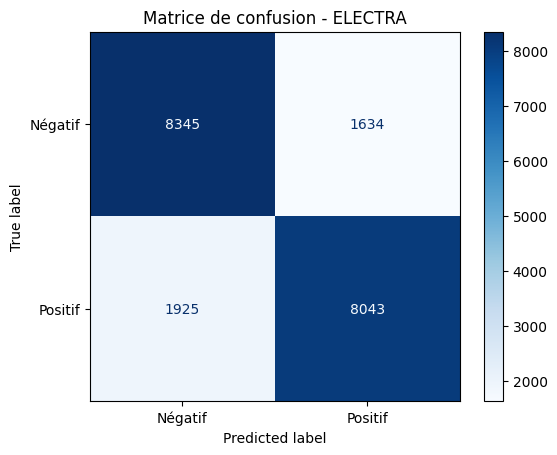

In [19]:
scores = evaluate_classification_metrics(
    y_true = y_test,
    y_pred = y_pred,
    model_name = "ELECTRA",
    save_path = "results/model_scores_logreg_vs_distilbert_vs_electra.csv"
)

## 6.1 - Rapport détaillé (précision, rappel, F1 par classe)

In [20]:
evaluate_model_predictions(
    y_true = y_test,
    y_pred = y_pred,
    save_path = "results/electra_classification_report.txt"
)

              precision    recall  f1-score   support

     Négatif       0.81      0.84      0.82      9979
     Positif       0.83      0.81      0.82      9968

    accuracy                           0.82     19947
   macro avg       0.82      0.82      0.82     19947
weighted avg       0.82      0.82      0.82     19947



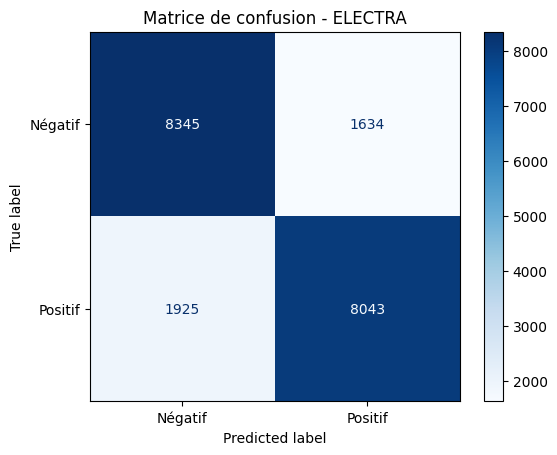

In [21]:
plot_confusion_matrix(
    y_true = y_test,
    y_pred = y_pred,
    labels = ["Négatif", "Positif"],
    title = "Matrice de confusion - ELECTRA"
)

# 7 - Prédictions sur 2000 tweets (alignement DistilBERT)

In [22]:
sample_preds = pd.DataFrame({
    "text": X_test[:2000],
    "label": y_test[:2000]
})

In [23]:
sample_preds["prediction"] = predict_with_electra(
    model = model,
    tokenizer = tokenizer,
    texts = sample_preds["text"],
    device = device,
    return_dataframe = False
)

In [24]:
sample_preds.to_csv("results/electra_predictions_sample.csv", index = False)

# 8 - Affichage graphique comparatif des modèles

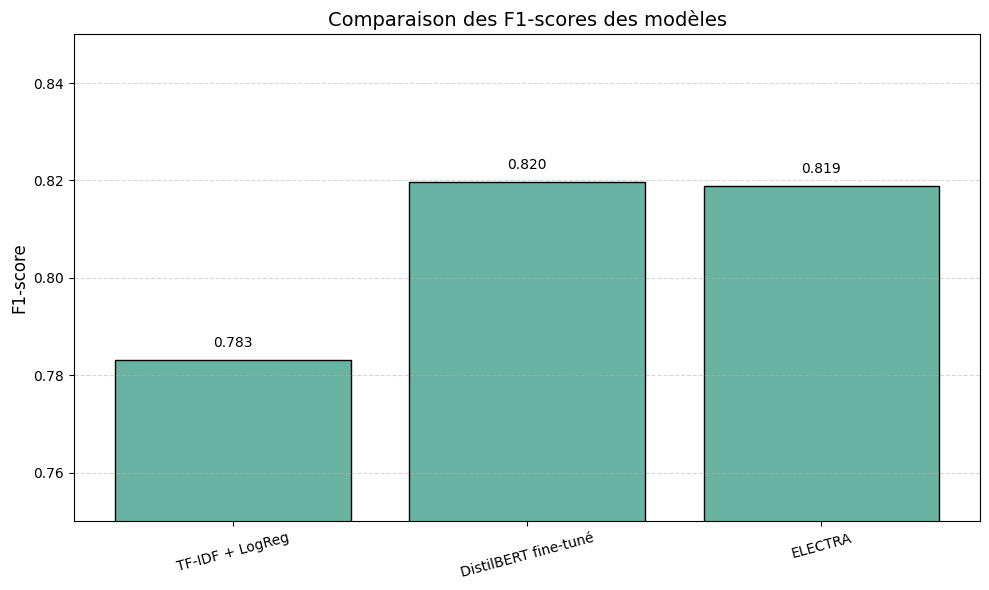

In [ ]:
# Chargement des scores
results_path = "results/model_scores_logreg_vs_distilbert_vs_electra.csv"

if os.path.exists(results_path):
    df_scores = pd.read_csv(results_path)

    # Création du graphique
    plt.figure(figsize = (10, 6))
    bars = plt.bar(df_scores["Modèle"], df_scores["F1-score"], edgecolor = "black", color = "#69b3a2")

    # Ajout des scores sur les barres
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height + 0.002, f"{height:.3f}",
                 ha = 'center', va = 'bottom', fontsize = 10)

    plt.title("Comparaison des F1-scores des modèles", fontsize = 14)
    plt.ylabel("F1-score", fontsize = 12)
    plt.ylim(0.75, 0.85)
    plt.grid(axis = "y", linestyle = "--", alpha = 0.5)
    plt.xticks(rotation = 15)
    plt.tight_layout()
    plt.show()
else:
    print("❌ Le fichier de résultats est introuvable :", results_path)
